# Simulation_Parameters

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 15 15:08:39 2022

@author: jjagiel
"""

import numpy as np

#######################
### Parameters Scan ###
#######################


An = 0.5                                       # Normal driving amplitude in Volt
As = 0.5                                       # Shear driving ampliude in Volt

Fn_0 = 840                                     # Resonance normal frequency in Hz
Fs_0 = 375                                     # Resonance shear frequency in Hz

L1 = 0.6                                       # Damping or energy dissipation related? (???)
L2 = 0.1                                       # Damping or energy dissipation related? (???)

phase = np.pi/2                                # Phase shift of the driving signal (w.r.t. resonance frequency?) ??? 

Amplitude_noise = 0.025                        # Noise on the output amplitude 

#############################
### Parameters experiment ###
#############################

eta_c = 500                                    # cst
density = 760*10**(-9)                         # kg/mm
eta = eta_c * density                          # Dynamic viscosity of the fluid? (???)

D = np.array([50, 40, 30, 20, 10])*10**(-3)    # Distance between probe and surface in millimeters (mm)
#D = np.array([60])*10**(-3)    # mm
R = (2.78/2)                                   # Radius of the probe in millimeter

Fn = np.array(np.linspace(800,900,60))         # Range of normal-frequencies to be tested in Hertz (Hz)
# Fn = np.array([900])                  

Fs = np.array(np.linspace(320,440,80))         # Range of shear-frequencies to be tested in Hertz (Hz)
# Fs = np.array([300])          

K0 = 2.35*10**5                                # Effective stiffness of the tuning fork prong with 
                                               # K0 = (Young's Modulus * area moment of intertia) / length of prong (???)

# Simulation_Function

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import gaussian, hilbert, argrelmax, argrelmin, find_peaks, correlate, correlation_lags
from scipy.integrate import odeint
from numpy.fft import fft, fftfreq
#import differint.differint as df
from scipy.signal import argrelextrema
from scipy.integrate import trapz
import TuningFork_Simulation_Parameters as TP


##################################################################################################################
# Function to calculate the displacement X based on the peak-input voltage, converted via sqrt(2) factor. 
# Frequency is converted to angular frequency and squared, as displacement scales inversely with angular frequency
# The 0.22 factor must be some system specific efficiency factor. Related to the piezo or geometry of fork or both? (???)
# Not sure why gravitational acceleration pops up in this equation? (???)
##################################################################################################################

def calcX(V,f):
    X = ((V*np.sqrt(2))*9.80665*10**9)/(0.22*(2*np.pi*f)**2)
    return X

##################################################################################################################
##################################################################################################################

def Width(x, y, t):
    # Calculate the threshold value Z as a fraction of the peak (max) value of y.
    # For example, if t = 0.5, Z will be set to half the peak value of y.
    Z = max(y) * t
    
    # Initialize variables for tracking the width's boundaries.
    r = 0                # Counter to iterate through y values
    a = 0                # 'a' will store the x-coordinate where y first meets or exceeds Z on the left side of the peak
    b = 0                # 'b' will store the x-coordinate where y falls below Z on the right side of the peak
    
    # Find the index of the peak in the y array. 
    # z is a tuple, where z[0] contains the index or indices where y reaches its maximum.
    z = np.where(y == max(y))
    
    # Loop through y values from the start until the peak index to find where y crosses the threshold Z.
    # This loop locates the x-coordinates 'a' and 'b' that define the width.
    while r < z[0]:
        
        # Check if y[r] is less than or equal to Z (threshold).
        # When this is true for the first time, store the corresponding x[r] as 'a'.
        if y[r] <= Z:
            a = x[r]
        
        # For points after the peak (right side), check if y has crossed back down to meet Z.
        # When this is true for the first time after the peak, store the corresponding x value as 'b'.
        if y[r + z[0]] >= Z:
            b = x[r + z[0] + 1]
        
        # Move to the next index in the y array.
        r = r + 1
    
    # Calculate and return the width as the difference between 'b' and 'a', ie x-distance over which y > Z
    return b - a


##################################################################################################################
# Note: The Lorentzian function describes how the amplitude decays from a central peak
# This function calculates the Lorentzian function value at each x. It defines a single Lorentzian peak shape 

# Parameters:
# - x: The input array (e.g., frequency or position) where the Lorentzian is evaluated
# - amp1: The peak amplitude of the Lorentzian
# - cen1: The center position of the peak on the x-axis
# - wid1: The half-width at half-maximum (HWHM) of the peak, defining how quickly the amplitude falls off

# - The numerator (amp1 * wid1^2) scales the peak to reach 'amp1' at 'cen1'
# - The denominator ((x - cen1)^2 + wid1^2) determines the width and shape of the peak
#   As x moves away from cen1, the denominator grows, and the function value decreases
##################################################################################################################

def _1Lorentzian(x, amp1, cen1, wid1):
    return amp1 * wid1**2 / ((x - cen1)**2 + wid1**2)


#############################
### Parameters, see above ### 
#############################

An = TP.An                        # V
As = TP.As                        # V

Fn_0 = TP.Fn_0                    # Hz
omega_0_N = 2*np.pi*Fn_0          # Convert to angular frequency

Fs_0 = TP.Fs_0                    # Hz
omega_0_S = 2*np.pi*Fs_0          # Convert to angular frequency

L1 = TP.L1                        # ???
L2 = TP.L2                        # ???



def Scan(Freq, Dist, i, s):
    Q = []                                                   # Prepare to store the quality factors for each distance
    Amplitude = []                                           # Prepare to store amplitude values for each distance
    Frequency = []                                           # Prepare to store corresponding frequencies

    omega = 2 * np.pi * Freq                                 # Converts Freq (array) to angular frequency (array)

    if s == "Shear":
        omega_0 = omega_0_S                                  # Set the resonance frequency if in Shear mode
    
    elif s == "Normal":
        omega_0 = omega_0_N                                  # Set the resonance frequency if in Normal mode

    # Runs a loop over each distance (between probe and surface) value in Dist 
    for d in Dist:
        print(d)                                             # Print the current distance being processed

        M = []                                               # Prepare list for M (???)

        # Prepare arrays to store ? (???)
        n_omega = len(Freq)                                  # Determine number of frequencies to be simulated
        TF_array = np.zeros(n_omega)                         # Prepare to store maximum amplitude values at each frequency
        Test_omega_array = np.zeros(n_omega)                 # Prepare to store corresponding frequencies
        
        K = 1 / d                                            # Set spring constant inversely proportional to distance
        damp = 1 / d                                         # Set damping factor inversely proportional to distance 

        
        for n in range(len(Freq)):                           # Loop through each frequency in Freq (= omega)
            print(Freq[n])

            n_period = 8000                                  # Number of periods to be simulated, per frequency
            n_points = 100                                   # Number of measured points (displacements) per period
            
            t = np.linspace(1 / Freq[n],                     # Period (T) of current frequency,
                            n_period / Freq[n],              # Total time for n_period cycles, 
                            (n_period - 1) * n_points)       # Total number of points (time-indices) in the array
            
            t = np.array(t)                                  # Convert to array. Already in array form?
            dt = t[1] - t[0]                                 # Calculate size of the time step (interval between points)

            ##############################
            ### The probe is vibrating ###
            ##############################
            
            if s == "Normal":
                a = An                                       # Use amplitude An for Normal mode
            elif s == "Shear":
                a = As                                       # Use amplitude As for Shear mode

            phase = TP.phase                                 # Retrieve the starting phase from the parameters
            
            h_0 = calcX(a, Freq[n]) * 10**3                  # Retrieve maximum amplitude of oscillation (h_0) in micrometers 

            
                 
            H = d + h_0 * np.cos(omega[n] * t + phase)       # Compute the total distance of the probe to the surface, H, with:  
                                                             # d = distance in equilibrium-position
                                                             # h_0 = maximum amplitude of the probes oscillation 
                                                             # cos... = factor determining the displacement for each t & Freq
                                                             # note since omega[n] = 1D array of freq. -> H = 1D array of distances

            # Ensure no negative distances; set H to 0 where it would be negative (representing contact)
            for m in range(len(H)):
                if H[m] < 0:
                    H[m] = 0

            # Define the amplitude noise level from the parameters
            Amplitude_noise = TP.Amplitude_noise

            # If i == 2 or i == 3, add random noise to the system response
            if i == 2:
                noise = np.array(Amplitude_noise * np.random.normal(0, 1, len(t)))
            elif i == 3:
                noise = np.array(Amplitude_noise * np.random.normal(0, 1, len(t)))

            # Define functions for calculating H and its derivative (H_Dot) over time
            def H(t):
                return d + h_0 * np.cos(omega[n] * t + phase)

            def H_Dot(t):
                return omega[n] * h_0 * -np.sin(omega[n] * t + phase)                 

            # if i == 4:
            
            #     for j in range(len(t)-1):
            #         c = 0
            #         b = t[j + 1]
            #         n = 10
                    
            #         x = np.linspace(c, b, n)
                    
            #         f = (H_Dot(x) / H(x)**2)*np.exp((b - x) / L1)
                    
            #         M = M + [(1 - L2/L1)*(H(t[j+1])**(2))/(L1*H_Dot(t[j+1])) * trapz(f,x) + L2/L1]
                
            #     M = np.array(M)
            
            t = np.delete(t, -1)                            # Removes last element of array t
        
# Define the differential equation governing the tuning fork's oscillatory behavior.
# This function returns a tuple containing the time derivatives of the state variables:
# - y[0]: Displacement (position) of the probe
# - y[1]: Velocity of the probe
def f(y, t):
    h = 0 + h_0 * np.cos(omega[n] * t + phase)              # Calculate the displacement (h) of the probe at time t

    # Case 1: Without noise
    if i == 1:
        # The first component is the velocity (time derivative of displacement y[0]),
        # and the second is the acceleration (based on force balance):
        # K * h: Force due to the fluid-sample interaction
        # -2 * damp * y[1]: Damping force
        # -omega_0^2 * y[0]: Restoring force from the tuning fork's stiffness
        a = (y[1], K * h - 2 * damp * y[1] - omega_0**2 * y[0])

    # Case 2: Add noise to the damping term
    if i == 2:
        # Noise affects the damping term, simulating fluctuations in energy dissipation.
        a = (y[1], K * h - 2 * damp * (1 + noise) * y[1] - omega_0**2 * y[0])

    # Case 3: Add noise to the stiffness term
    if i == 3:
        # Noise affects the stiffness term, simulating fluctuations in the restoring force.
        a = (y[1], K * h - 2 * damp * y[1] - omega_0**2 * (1 + noise) * y[0])

    # Case 4: Advanced interaction using a distance-dependent model
    if i == 4:
        # Define the integration limits for modeling a complex interaction.
        c = 0  # Lower limit of integration
        b = t  # Upper limit of integration (current time)
        m = 10  # Number of points for integration

        # Generate an array of evenly spaced points between c and b for integration.
        x = np.linspace(c, b, m)

        # Define a distance-dependent damping function f(x), which includes:
        # - H_Dot(x) / H(x)^2: A term representing velocity and inverse distance effects
        # - exp((b - x) / L1): An exponential decay factor for damping
        f = (H_Dot(x) / H(x)**2) * np.exp((b - x) / L1)

        # Use the trapezoidal rule to calculate the integral of f(x).
        # The result is scaled by terms related to the interaction strength (1 - L2/L1), ...
        # ...the damping parameter L1, and the velocity H_Dot(t).
        M = (1 - L2 / L1) * (H(t)**2) / (L1 * H_Dot(t)) * trapz(f, x) + L2 / L1

        # Combine the interaction model with the force balance equation.
        # M replaces the constant damping or stiffness terms used in other cases.
        a = (y[1], K * h - 2 * damp * M * y[1] - omega_0**2 * y[0])

    # Return the tuple containing the time derivatives (velocity and acceleration).
    return a
            
            # Not sure why this is calculated again here?
            h = 0 + h_0 * np.cos(omega[n] * t + phase)
            
            # Set initial conditions for solving the differential equation.
            # y0[0]: Initial displacement proportional to the driving force (K * h[0]).
            # y0[1]: Initial velocity, estimated as K * h[0] / dt.
            y0 = [K * h[0], K * h[0] / dt]
            
            # Solve ODE
            f_sol = odeint(f, y0, t)
            y_sol = f_sol[:,0]          # Solution of F
            
            
            plt.figure("Probe Displacement Over Time")
            plt.xlabel("Time (s)")                            # X-axis label for time
            plt.ylabel("Displacement (μm)")                   # Y-axis label for probe displacement
            plt.title("Probe Displacement Over Time")         # Title for the plot
            plt.plot(t,y_sol)                                 # Plot displacement as function of time 
            
            # Removing the initial transient part of the solution (only applies for i != 4).
            if i != 4 :
                n_period = 100                                # Number of periods to keep
                t = t[-n_period*n_points - 1:]                # Keep the last n_period cycles
                t = t - t[0]                                  # Normalize time to start at 0
                y_sol = y_sol[-n_period*n_points - 1:]        # Keep corresponding displacement data
            
            size = len(t)                                     # Size of truncated time-series array
            
            X = fft(y_sol)                                    # Compute the FFT of the displacement solution
            Te = t[-1] / (len(t) - 1)                         # Time sampling interval (inverse of sampling rate)
            freq = fftfreq(y_sol.size, d=dt)                  # Frequency components corresponding to FFT
            
            N = int(len(t)/2)                                 # Number of positive frequencies
            
            X_abs = np.abs(X[:N])                             # Absolute value for the amplitude for positive frequency
            X_norm = X_abs/N                                  # Normalisation of the amplitude
            # X_norm = X_abs
            freq_pos = freq[:N]                               # Keep only positive frequencies
            
            # Plot the FFT result (amplitude vs. frequency)
            plt.figure("FFT")
            plt.xlabel("Frequency (Hz)")                      # X-axis label for frequency
            plt.ylabel("Normalized Amplitude")                # Y-axis label for normalized amplitude
            plt.title("Frequency Spectrum of Probe Motion")   # Title for the FFT plot
            plt.plot(freq_pos,X_norm)
            
            # Identify the local maxima in the normalized amplitude spectrum
            maxi = argrelextrema(X_norm, np.greater)
            maxi = maxi[0]
            
            
            # Ignore pic at 0 (if it exist)
            l = 0
                
            # if len(maxi) > 1:
            #     while freq_pos[maxi[l]] < 400:
            #         l = l + 1
            
            # Store the peak amplitude and corresponding frequency for each iteration
            TF_array[n] = X_norm[maxi[l]]               # We take the maximum value of the amplitude
            Test_omega_array[n] = freq_pos[maxi[l]]     # And the corresponding frequency
            
        # Finish 
        from here    
        Amplitude = Amplitude + [TF_array]              # 
        Frequency = Frequency + [Test_omega_array]
        
        plt.figure("Scan")
        plt.plot(Test_omega_array,TF_array)
        
        l = np.linspace(0.5,0.99)
        
        w = []
        for t in l:
            w = w + [float(Width(Test_omega_array, TF_array, t))]
        
        # plt.figure("FWHM")
        
        # plt.plot(l, w, '+', label = 'D = '+str(d))
        # plt.xlabel('Maxima %')
        # plt.ylabel('Width')
        # plt.legend()
        
        
        # n = 0
        # while w[n] > 600:
        #     n = n + 1
        
        z = np.where(TF_array == max(TF_array))
        
        Q = Q + [float(Freq[z[0]])/w[0]]
        
        ###################
        ### Save a file ###
        ###################

        if i == 1 or i == 4:

            print("Create a file...")
            
            with open('Simulation_Scan_'+str(s)+"_i_"+str(i)+"_Number_of_D_"+str(len(Dist))+"_of_F_"+str(len(Freq))+".TXT", 'a') as f:
                f.write('D [mm], Frequency[Hz], test Frequency, Amplitude Scan, Quality factor \n')
    
                for v in range(len(Freq)):
                    f.write(str(d)+','+ str(Freq[v])+','+ str(Frequency[-1][v])+','+ str(Amplitude[-1][v])+','+ str(Q[-1])+'\n')
        if i == 2 or i == 3:
            
            print("Create a file...")
            
            with open('Simulation_Scan_'+str(s)+"_i_"+str(i)+"_Number_of_D_"+str(len(Dist))+"_of_F_"+str(len(Freq))+"_Amplitude_Noise_"+str(Amplitude_noise)+".TXT", 'a') as f:
                f.write('D [mm], Frequency[Hz], test Frequency, Amplitude Scan, Quality factor \n')
    
                for v in range(len(Freq)):
                    f.write(str(d)+','+ str(Freq[v])+','+ str(Frequency[-1][v])+','+ str(Amplitude[-1][v])+','+ str(Q[-1])+'\n')
    f.close()

    return [Amplitude, Frequency, Q]

##################################################################################################################
##################################################################################################################

# Simulation_Experiment

0.05
800.0
801.6949152542373
803.3898305084746
805.0847457627119
806.7796610169491
808.4745762711865
810.1694915254237
811.8644067796611
813.5593220338983
815.2542372881356
816.9491525423729
818.6440677966102
820.3389830508474
822.0338983050848
823.728813559322
825.4237288135594
827.1186440677966
828.8135593220339
830.5084745762712
832.2033898305085
833.8983050847457
835.5932203389831
837.2881355932203
838.9830508474577
840.6779661016949
842.3728813559322
844.0677966101695
845.7627118644068
847.457627118644
849.1525423728814
850.8474576271186
852.542372881356
854.2372881355932
855.9322033898305
857.6271186440678
859.3220338983051
861.0169491525423
862.7118644067797
864.4067796610169
866.1016949152543
867.7966101694915
869.4915254237288
871.1864406779661
872.8813559322034
874.5762711864406
876.271186440678
877.9661016949152
879.6610169491526
881.3559322033898
883.0508474576271
884.7457627118644
886.4406779661017
888.1355932203389
889.8305084745763
891.5254237288135
893.2203389830509
894

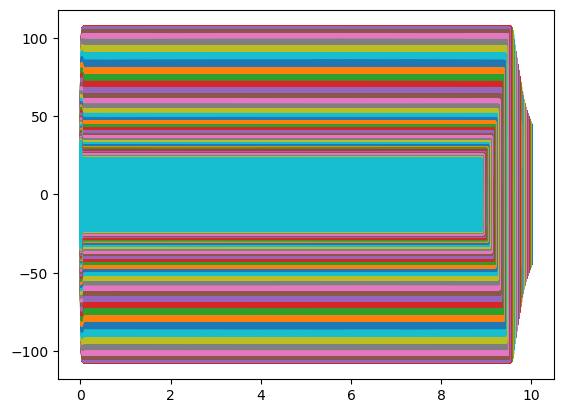

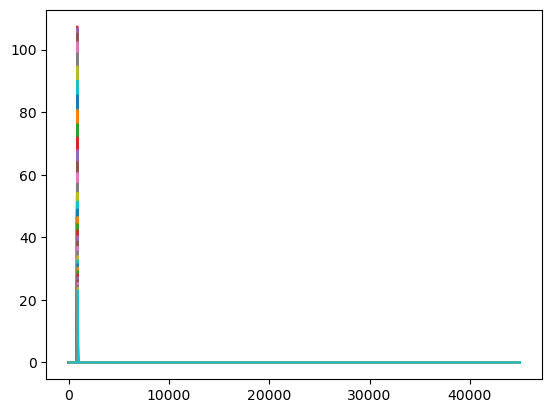

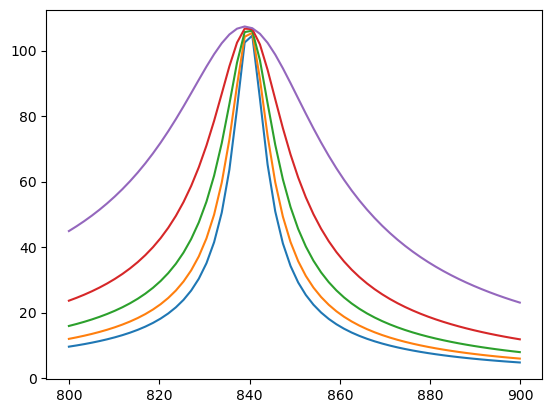

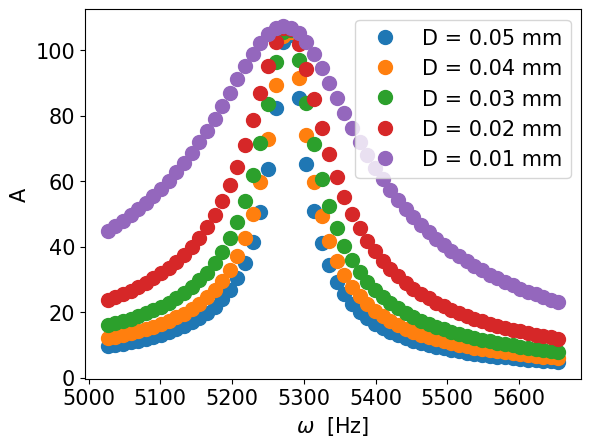

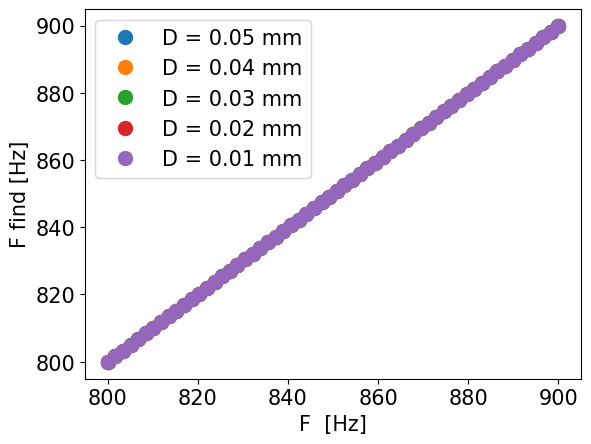

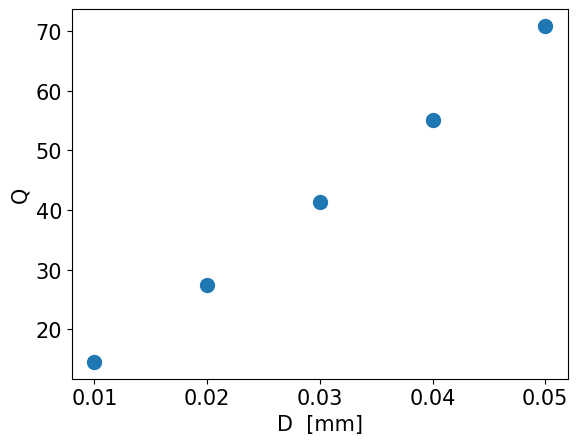

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 15 15:08:37 2022

@author: jjagiel
"""

import time
import re
import numpy as np
import matplotlib.pyplot as plt


import TuningFork_Simulation_Function as TF
import TuningFork_Simulation_Parameters as TP


"""
Definition of the parameter on the function Scan(Freq, Dist, i, s):
    
    i is for choose the harmonique equation 
    i = 1 --> forced harmonic equation, 
    i = 2 --> forced harmonic equation with damping noise
    i = 3 --> forced harmonic equation with frequency noise. 
    i = 4 --> Viscoelastic liquid with no noise (Not working yet)
    
    s is for choose the normal or shear direction
    
    At the end you have [the amplitude for one scan, Verification for the frequency, the quality factor]

"""

##########################################
### Changing parameters for simulation ###
##########################################

Make_one_simulation = 'Yes'
i = 1
s = 'Normal'

Read_Data = 'No'
fname = 'Simulation_Scan_Normal_i_1_Number_of_D_1_of_F_30.txt'


#######################################
### Characteristics of the experiment ###
#######################################

eta = TP.eta          # cst
density = TP.density  # kg/mm
eta = eta * density 

D = TP.D
R = TP.R       # mm


Fn = TP.Fn

Fs = TP.Fs

K0 = TP.K0



###################################################################################################################
###################################################################################################################
###################################################################################################################



###########################
### Make one simulation ###
###########################

if Make_one_simulation == 'Yes':
    if s == "Normal":
        F = Fn
        F2 = Fs
    
    if s == "Shear":
        F = Fs
        F2 = Fn
    
    Scan_result = TF.Scan(F, D, i, s)
    
    Freq = []
    for d in range(len(D)):
        Freq = Freq + [F]
    Freq_test = Scan_result[1]
    Amp = Scan_result[0]
    QFactor = Scan_result[2]
    
###################
### Save a file ###
###################

if Make_one_simulation == 'Yes':
    print("Create a file...")
    
    with open('Simulation_Scan_'+str(s)+"_i_"+str(i)+"_Number_of_D_"+str(len(D))+"_of_F_"+str(len(F))+".TXT", 'w') as f:
        f.write('D [mm], Frequency[Hz], test Frequency, Amplitude Scan, Quality factor \n')

        for d in range(len(D)):
            for v in range(len(Scan_result[0][0])):
                f.write(str(D[d])+','+ str(F[v])+','+ str(Scan_result[1][d][v])+','+ str(Scan_result[0][d][v])+','+ str(Scan_result[2][d])+'\n')


#########################
### Read a file saved ###
#########################



if Read_Data == 'Yes':
    print("Read a file...")
    
    F_test_d, A_d, Q_d = [],[],[]
    F_test, A = [], []
    F_d, F = [], []
    D = []
    
    f=open(fname,'r')
    f.readline()
    
    i = 0
    j = 0
    for ligne in f:
        mots=ligne.split(',')
        mots = [re.sub('\n','',mot) for mot in mots]
        
        
        
        if i == 0:
            d_ini = float(mots[0])
            D.append(float(mots[0]))
            print(d_ini)
            print(i)
        
        
        if float(mots[0]) == d_ini:
            i = 1
            
            F_d.append(float(mots[1]))
            F_test_d.append(float(mots[2]))
            A_d.append(float(mots[3]))
            Q_d.append(float(mots[4]))
            
                
                    
                
        elif float(mots[0]) != d_ini:
            d_ini = float(mots[0])
            D.append(float(mots[0]))
            
            F_test = F_test + [F_test_d]
            F = F + [F_d]
            A = A + [A_d]
            
            F_test_d, A_d, F_d = [],[], []
            
            F_test_d.append(float(mots[2]))
            F_d.append(float(mots[1]))
            A_d.append(float(mots[3]))
            
        
            
            
    F_test = F_test + [F_test_d]
    F = F + [F_d]
    A = A + [A_d]
    
    Q_ini = Q_d[0]
    Q = [Q_ini]
    for k in range(len(Q_d)):
        if Q_d[k] != Q_ini:
            Q = Q + [Q_d[k]]
            Q_ini = Q_d[k]
    
    Freq = F
    Freq_test = F_test
    Amp = A
    QFactor = Q

####################
### Some Analyse ###
####################



############
### Scan ###
############

for d in range(len(D)):
    plt.figure('Scan Amplitude')
    plt.plot(2*np.pi*np.array(Freq[d]), Amp[d], 'o', label = 'D = '+str(D[d])+ ' mm', markersize = 10)
    plt.xlabel('$\omega$  [Hz]', fontsize = 15)
    plt.ylabel('A', fontsize = 15)
    plt.tick_params(axis='x', labelsize= 15)
    plt.tick_params(axis='y', labelsize= 15)
    plt.legend(fontsize = 15)
    
    plt.figure('Frequency test')
    plt.plot(Freq[d], Freq_test[d], 'o', label = 'D = '+str(D[d])+ ' mm', markersize = 10)
    plt.xlabel('F  [Hz]', fontsize = 15)
    plt.ylabel('F find [Hz]', fontsize = 15)
    plt.tick_params(axis='x', labelsize= 15)
    plt.tick_params(axis='y', labelsize= 15)
    plt.legend(fontsize = 15)
    
    
plt.figure('Quality factor')
plt.plot(D, QFactor, 'o', markersize = 10)
plt.xlabel('D  [mm]', fontsize = 15)
plt.ylabel('Q', fontsize = 15)
plt.tick_params(axis='x', labelsize= 15)
plt.tick_params(axis='y', labelsize= 15)



###################
### Slip length ###
###################


# color = ['r', 'b', 'g']

# def f(x):
#     return (1/(3*x))*((1 + 1/(6*x))*np.log(1 + x*6) - 1)

# b = np.linspace(1,200000,4)      # nm
# b = np.array(b) * 10**(-6)

# D = np.linspace(10,50,10)      # microm
# D = np.array(D) * 10**(-3)

# omega_0 = 2*np.pi*840

# slope = []

# plt.figure('Slip length')
# for i in range(len(b)):
#      Z = ((6*np.pi*omega_0*eta*(R**2))/D )*f(b[i]/D)
#      plt.plot(D,1/Z, 'o', markersize = 12, label = 'b = '+str(b[i])+' mm')
#      Linear = np.polyfit(D, 1/Z, 1)
#      slope = slope + [Linear[0]]
#      plt.xlabel("D [mm]")
#      plt.ylabel('1/Z')
#      plt.legend()
     
# plt.figure('Slope')
# plt.plot(b, slope, 'o')
# plt.xlabel("b [mm]")
# plt.ylabel('Slope')



# plt.figure('Slip length 2')
# D = np.linspace(10,50,3)      # microm
# D = np.array(D) * 10**(-3)

# b = np.linspace(1,200000,20)      # nm
# b = np.array(b) * 10**(-6)

# for i in range(len(D)):
#      Z = ((6*np.pi*omega_0*eta*(R**2))/D[i] )*f(b/D[i])
#      plt.plot(b,1/Z, 'o', markersize = 12, label = 'D = '+str(D[i])+' mm', color = color[i])
#      plt.xlabel("b [mm]")
#      plt.ylabel('1/Z')
#      plt.legend()
     
#      Z = ((6*np.pi*omega_0*eta*(R**2))/D[i] )
#      plt.plot(0,1/Z, 'o', markersize = 12, color = color[i])
#      plt.legend()

